In [495]:
from astropy.io import fits
import fitsio
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import numpy as np
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve2d
import sys
sys.path.append('../python/')
import chroma
reload(chroma)
from tqdm import tqdm
from astropy.modeling import models, fitting

In [520]:
psfdir='../psf_models/psf_data_8_18_08/PSF_Mono/'
fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,13,13.1))
h=sio.loadmat(fnames[0])
psf=np.zeros((len(fnames),np.shape(h['psf'])[0],np.shape(h['psf'])[1]))
res=h['grid_res'][0][0]
lam=[]
for i,f in enumerate(fnames):
    h=sio.loadmat(f)
    psf[i,:,:]=h['psf']
    lam.append(f.split('_')[-1][0:-4])
    
PRFx = np.arange(0., np.shape(psf[0])[0] + 0.)-np.shape(psf[0])[0]/2
PRFy = np.arange(0., np.shape(psf[0])[1] + 0.)-np.shape(psf[0])[0]/2
PRFx*=0.03
PRFy*=0.03
PRFX,PRFY=np.meshgrid(PRFx,PRFy)    
cx=PRFX[0][np.where(PRFX[0]>=0)[0][0]:np.where(PRFX[0]<1)[0][-1]]
cy=PRFY[:,0][np.where(PRFY[:,0]>=0)[0][0]:np.where(PRFY[:,0]<1)[0][-1]]
cx,cy=np.meshgrid(cx,cy)
prf=np.copy(cx)*0.+1.
psf_c=convolve2d(psf[11,:,:],prf,mode='same')


psf_c/=np.nansum(psf_c)

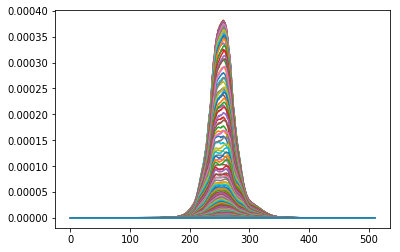

In [521]:
_=plt.plot(psf_c)

In [203]:
reload(chroma)


def compare(infile='../data/test1/blue_13.fits',PRFX=PRFX,PRFY=PRFY,psf_c=psf_c,stamps=[0]):
    h=fits.open(infile)
    data = fitsio.read(infile,ext=1,columns='FLUX')
    aper=(h[2].data)
    for a in aper:
        a[np.where(a!=3)]=0.
    aper/=3
    output=h[0].header['OUTPUT']

    ra=h[0].header['RA_OBJ']
    dec=h[0].header['Dec_OBJ']
            
    FLFRCSAP=h[1].header['FLFRCSAP']
    CROWDSAP=h[1].header['CROWDSAP']
    
    if isinstance(h[0].header['GRCOLOR'],float)==False:
        gr=-99
    else:
        gr=h[0].header['GRCOLOR']
        
    if isinstance(h[0].header['GMAG'],float)==False:
        gmag=-99
    else:
        gmag=h[0].header['GMAG']
    if isinstance(h[0].header['IMAG'],float)==False:
        imag=-99
    else:
        imag=h[0].header['IMAG']
        

        
        
        
    frames=data[stamps]
    xstretch=np.zeros(len(frames))
    ystretch=np.zeros(len(frames))
    tot=np.zeros(len(frames))
    for i,frame in enumerate(frames):
        x,y=np.arange(np.shape(frame)[1]),np.nansum(frame,axis=0)/np.nanmean(np.nansum(frame,axis=0))
        x_fit,y_fit=PRFx,np.nansum(psf_c,axis=0)/np.nanmean(np.nansum(psf_c,axis=0))
        shift,flux,xstretch[i]=fitprf1d(x,y,x_fit,y_fit,initshift=-float(np.shape(frame)[1])/2)
        
        x,y=np.arange(np.shape(frame)[0]),np.nansum(frame,axis=1)/np.nanmean(np.nansum(frame,axis=1))
        x_fit,y_fit=PRFx,np.nansum(psf_c,axis=1)/np.nanmean(np.nansum(psf_c,axis=1))
        shift,flux,ystretch[i]=chroma.fitprf1d(x,y,x_fit,y_fit,initshift=-float(np.shape(frame)[0])/2,n=100,plot=True,count=5)
        tot[i]=(np.nansum(frame*aper)*FLFRCSAP)/CROWDSAP
    if len(xstretch)==1:
        xstretch=xstretch[0]
        ystretch=ystretch[0]
        tot=tot[0]
    result={'xstretch':xstretch,'ystretch':ystretch,'tot':tot,'gr':gr,'gi':gmag-imag,'ra':ra,'dec':dec,'output':output,'FLFRCSAP':FLFRCSAP,'CROWDSAP':CROWDSAP}
    return result

        


0.34487144314
0.418016982495
0.442945940731
0.51381103329
0.560583158033


{'CROWDSAP': 0.9991,
 'FLFRCSAP': 0.9742,
 'dec': 42.99311,
 'gi': -0.39899999999999913,
 'gr': -0.191,
 'output': 1,
 'ra': 290.36489,
 'tot': 305788.78807536891,
 'xstretch': 0.90545288409193836,
 'ystretch': 0.9712485981350486}

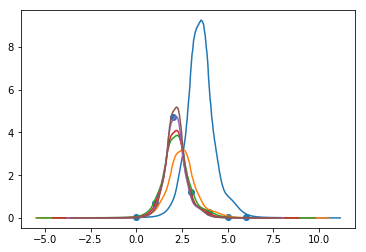

In [204]:
compare()

In [151]:
r=[]
fnames=glob('/Volumes/Remove Disk/chromaTPFs/*.fits')
for i,f in tqdm(zip(xrange(len(fnames)),fnames)):
    r.append(compare(f))


 17%|█▋        | 64/367 [04:40<25:43,  5.09s/it]

KeyboardInterrupt: 

In [152]:
ra,dec,mag,xs,ys,gr,gi=[],[],[],[],[],[],[]
for i in r:
    ra.append(i['ra'])
    dec.append(i['dec'])
    mag.append(i['tot'])
    xs.append(i['xstretch'])
    ys.append(i['ystretch'])
    gr.append(i['gr'])
    gi.append(i['gi'])
xs=np.asarray(xs)
ys=np.asarray(ys)
gr=np.asarray(gr)
gi=np.asarray(gi)

In [629]:
from scipy.optimize import minimize
fnames=glob('/Volumes/Remove Disk/chromaTPFs/*.fits')


def fitpsf(infile='../data/test1/blue_13.fits',PRFX=PRFX,PRFY=PRFY,psf_c=psf_c,stamps=[0],plot=False):
    h=fits.open(infile)
    data = fitsio.read(infile,ext=1,columns='FLUX')
    frame=data[0]
    fit=fitting.LevMarLSQFitter()
   
    aper=(h[2].data)
    for a in aper:
        a[np.where(a!=3)]=0.
    aper/=3
    output=h[0].header['OUTPUT']

    ra=h[0].header['RA_OBJ']
    dec=h[0].header['Dec_OBJ']
            
    FLFRCSAP=h[1].header['FLFRCSAP']
    CROWDSAP=h[1].header['CROWDSAP']
    
    if isinstance(h[0].header['GRCOLOR'],float)==False:
        gr=-99
    else:
        gr=h[0].header['GRCOLOR']
        
    if isinstance(h[0].header['GMAG'],float)==False:
        gmag=-99
    else:
        gmag=h[0].header['GMAG']
    if isinstance(h[0].header['IMAG'],float)==False:
        imag=-99
    else:
        imag=h[0].header['IMAG']
        
        

    def psfx(vals,return_fit=False):
        x_fit,y_fit=np.copy(PRFx),np.nansum(psf_c,axis=1)
        x_fit+=vals[0]
        y_fit*=vals[1]
        x2=(x_fit-x_fit[np.argmax(y_fit)])*vals[2]+x_fit[np.argmax(y_fit)]
        if return_fit==True:
            return x2,y_fit
        y_fit=np.interp(x,x2,y_fit)        
        chi=(1./float(len(y_fit)))*np.nansum((y-y_fit)**2/(y))**0.5
        if return_fit==False:
            return chi
    def psfy(vals,return_fit=False):
        x_fit,y_fit=np.copy(PRFy),np.nansum(psf_c,axis=0)
        x_fit+=vals[0]
        y_fit*=vals[1]
        x2=(x_fit-x_fit[np.argmax(y_fit)])*vals[2]+x_fit[np.argmax(y_fit)]
        if return_fit==True:
            return x2,y_fit
        y_fit=np.interp(x,x2,y_fit)        
        chi=(1./float(len(y_fit)))*np.nansum((y-y_fit)**2/(y))**0.5
        if return_fit==False:
            return chi

    frames=data[stamps]
    xstretch=np.zeros(len(frames))
    ystretch=np.zeros(len(frames))
    xscale=np.zeros(len(frames))
    yscale=np.zeros(len(frames))
    tot=np.zeros(len(frames))
    
    for i,frame in enumerate(frames):
        tot[i]=(np.nansum(frame))
        x,y=np.arange(np.shape(frame)[0]),np.nansum(frame,axis=1)
        g_init=models.Gaussian1D(mean=float(len(x))/2.,amplitude=tot[i])
        g=fit(g_init,x,y)
        initial_guess=[g.mean.value,g.amplitude.value*50.,1.]
        x_fit,y_fit=psfy(initial_guess,return_fit=True)
        res=minimize(psfx,initial_guess,bounds=((-10,10),(tot[i]*10.,100.*tot[i]),(0.7,1.3)))
        xstretch[i]=res.x[2]
        xscale[i]=res.x[1]
        if plot==True:
            plt.scatter(x,y)
            x_fit,y_fit=psfy(res.x,return_fit=True)
            plt.plot(x_fit,y_fit,ls='--')


        x,y=np.arange(np.shape(frame)[1]),np.nansum(frame,axis=0)
        g_init=models.Gaussian1D(mean=float(len(x))/2.,amplitude=tot[i])
        g=fit(g_init,x,y)
        initial_guess=[g.mean.value,g.amplitude.value*50.,1]
        res=minimize(psfy,initial_guess,bounds=((-10,10),(0,1E10),(0.7,1.3)))
        ystretch[i]=res.x[2]
        yscale[i]=res.x[1]
        if plot==True:
            plt.scatter(x,y)
            x_fit,y_fit=psfy(res.x,return_fit=True)
            plt.plot(x_fit,y_fit,ls='--')
    
    if len(xstretch)==1:
        xstretch=xstretch[0]
        ystretch=ystretch[0]
        xscale=xscale[0]
        yscale=yscale[0]
        tot=tot[0]
    result={'xscale':xscale,'yscale':yscale,'xstretch':xstretch,'ystretch':ystretch,'tot':tot,'gr':gr,'gi':gmag-imag,'ra':ra,'dec':dec,'output':output,'FLFRCSAP':FLFRCSAP,'CROWDSAP':CROWDSAP}
    return result


{'CROWDSAP': 0.9987,
 'FLFRCSAP': 0.968,
 'dec': 44.07186,
 'gi': 0.30599999999999916,
 'gr': 0.275,
 'output': 4,
 'ra': 291.45912,
 'tot': 490643.65625,
 'xscale': 12325074.952014269,
 'xstretch': 1.0874948508387203,
 'yscale': 15928215.248752151,
 'ystretch': 0.9368162954609035}

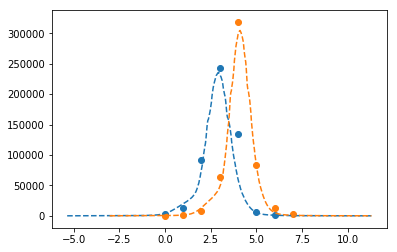

In [630]:
fnames=glob('/Volumes/Remove Disk/chromaTPFs/*.fits')

fitpsf(fnames[100],plot=True)

In [435]:
r=[]
fnames=glob('/Volumes/Remove Disk/chromaTPFs/*.fits')

for f in tqdm(fnames):
    r.append(fitpsf(f))  

 51%|█████     | 399/783 [05:11<04:45,  1.34it/s]

KeyboardInterrupt: 

In [436]:
ra,dec,mag,xs,ys,gr,gi,xsc,ysc=[],[],[],[],[],[],[],[],[]
for i in r:
    ra.append(i['ra'])
    dec.append(i['dec'])
    mag.append(i['tot'])
    xs.append(i['xstretch'])
    ys.append(i['ystretch'])
    xsc.append(i['xscale'])
    ysc.append(i['yscale'])
    gr.append(i['gr'])
    gi.append(i['gi'])
xs=np.asarray(xs)
ys=np.asarray(ys)
gr=np.asarray(gr)
gi=np.asarray(gi)

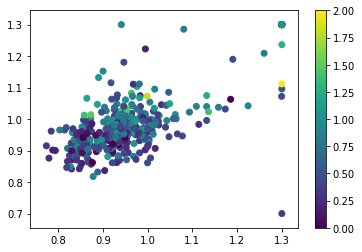

In [437]:
pos=(gr>-50)&(gr<50)
plt.scatter(xs[pos],ys[pos],c=gr[pos],vmin=0.,vmax=2)
cbar=plt.colorbar()

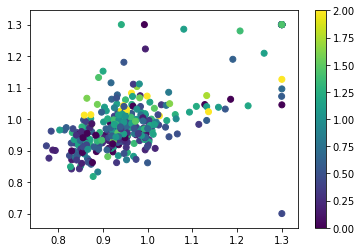

In [438]:
pos=(gi>-50)&(gi<50)
plt.scatter(xs[pos],ys[pos],c=gi[pos],vmin=0.,vmax=2)
cbar=plt.colorbar()